In [110]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration raw data

In [2]:
df=pd.read_json("/Users/David/code/Clementinelalande/marbotic/raw_data/export_23-5_minified.json")

In [79]:
df.shape

(1320229, 16)

In [80]:
df.columns

Index(['city', 'client_event_time', 'country', 'device_model', 'event_id',
       'event_type', 'is_attribution_event', 'language', 'os_version',
       'region', 'session_id', 'start_version', 'user_creation_time',
       'user_id', 'user_properties', 'event_properties'],
      dtype='object')

In [81]:
df.event_type.unique()

array(['[Activity] Good Answer', '[Activity] Wrong Answer',
       '[Activity] Stop', '[Activity] Start', '[Action] Click',
       '[Scene] Leave', '[Scene] Enter', '[Game] Pause',
       '[Scaffolding] Scaffolding', '[Game] Start', '[Error] Error',
       '[Game] Stop', '[OB] CommPreview', '[OB] DoYouHaveKit',
       '[OB] HasKitYes', '[OB] Email', '[OB] VerifCode',
       '[Activation] Game', '[OB] HasKitNo', '[OB] DiscoverTrial',
       '[OB] ClickTrial', '[Account] Sign In', '[Profile] Create',
       '[Profile] Update', '[OB] ProductSelection', '[OB] ProductHelp',
       '[OB] Type', '[Account] Sign Up', '[OB] ProfileName',
       '[OB] ProfileBirthdate', '[Activation] New Activation',
       '[Activation] Product', '[Activation] Piece', '[OB] Success',
       '[OB] ProductActivation', '[Scaffolding] Reset', '[OB] TrialStart',
       '[Account] Update Request', '[Profile] Delete', '[Popup] Open',
       '[Popup] Close', '[Account] Update Success', '[Account] Sign Out',
       '[Pr

In [82]:
df.head()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,user_properties,event_properties
0,Dallas,2022-03-01 00:57:25.903,United States,"iPad13,4",1110,[Activity] Good Answer,False,English,15.3,Texas,1646095346396,1.0.7,2021-12-28 01:29:38.094,67531,"{'Newsletter': 'False', 'Products': ['Smart Le...","{'[Activity] Name': 'LinePanties', '[Activity]..."
1,Dallas,2022-03-01 00:57:41.878,United States,"iPad13,4",1111,[Activity] Wrong Answer,False,English,15.3,Texas,1646095346396,1.0.7,2021-12-28 01:29:38.094,67531,"{'Newsletter': 'False', 'Products': ['Smart Le...","{'[Activity] Name': 'LinePanties', '[Activity]..."
2,Toronto,2022-03-01 00:57:28.175,Canada,"iPad12,1",1430,[Activity] Stop,False,English,15.2,Ontario,1646096085235,1.3.1,2021-07-19 20:24:36.326,60882,"{'Newsletter': 'True', 'Products': ['Smart Let...","{'[Activity] Name': '1.2', '[Game] Code': 'Mar..."
3,Toronto,2022-03-01 00:57:28.177,Canada,"iPad12,1",1431,[Activity] Start,False,English,15.2,Ontario,1646096085235,1.3.1,2021-07-19 20:24:36.326,60882,"{'Newsletter': 'True', 'Products': ['Smart Let...","{'[Activity] Name': '1.3', '[Game] Code': 'Mar..."
4,Toronto,2022-03-01 00:57:38.278,Canada,"iPad12,1",1432,[Activity] Stop,False,English,15.2,Ontario,1646096085235,1.3.1,2021-07-19 20:24:36.326,60882,"{'Newsletter': 'True', 'Products': ['Smart Let...","{'[Activity] Name': '1.3', '[Game] Code': 'Mar..."


In [109]:
df.event_properties[4]

{'[Activity] Name': '1.3',
 '[Game] Code': 'Marbotic',
 '[Time] Spent': 10,
 '[Scene] Name': 'Counting_Home',
 '[Profile] Age (days)': 2423,
 '[Game] Language': 'en_US',
 '[Activity] Solved': False,
 '[Scaffolding] Level': 11,
 '[Scene] Section': 'UP100'}

In [130]:
df.user_properties[4]

{'Newsletter': 'True',
 'Products': ['Smart Letters', 'Smart Numbers'],
 'Pieces': ['Uppercase Letters', 'Numbers'],
 'Language': 'English',
 'Type': 'Parent',
 'Country': 'CA',
 'Games': ['Marbotic Numbers',
  'Marbotic Letters',
  'Alphamonster',
  'Vocabubble',
  'Bla Bla Box',
  'Lil Reader',
  'Up To 100',
  '10 Fingers',
  'More Or Less',
  'Marbotic']}

In [83]:
user_properties_df=df.copy()

In [84]:
user_properties=user_properties_df[["user_id","user_properties"]]

# Import Dataframe with a query

## Connexion à Google Query

In [85]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=PoQsXFrUUsLui0bniQSz9njix6vkmV&access_type=offline&code_challenge=S3iaAqXEe7U5N46YKdeJCKShEw-o-S2tI7TMNTfuXWM&code_challenge_method=S256


You are now logged in as [david.periers@gmail.com].
Your current project is [marbotic].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [86]:
!gcloud projects list

PROJECT_ID              NAME              PROJECT_NUMBER
marbotic                Marbotic          566474310042
symmetric-curve-346916  My First Project  175516577791
wagon-bootcamp-346916   Wagon bootcamp    697736453840


In [87]:
!gcloud config set project marbotic

Updated property [core/project].


In [88]:
!bq ls

/usr/local/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/platform/bq/bq.py:41: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
     datasetId      
 ------------------ 
  marbotic_dataset  


In [89]:
!cat credentials

cat: credentials: No such file or directory


## Fonction extract with a query

In [5]:
from google.oauth2 import service_account

def extract():
    # Construct a BigQuery client object.

    key_path = "/Users/David/code/dperiers/GITHUB_NICKNAME/gcp/marbotic-587600c2c13f.json"

    credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
    
    client = bigquery.Client(project="marbotic", credentials=credentials)

    query = """
        SELECT *
        FROM `marbotic.marbotic_dataset.events`
      
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [213]:
extract()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id
0,None,2022-05-12 21:28:00.367000+00:00,United States,"iPad8,11",3135,[Toast] Appear,False,English,15.4.1,Wisconsin,1652390875674,1.0.9,2022-03-09 23:24:23.096000+00:00,71150,1307980
1,None,2022-05-12 21:28:05.614000+00:00,United States,"iPad8,11",3138,[Toast] Disappear,False,English,15.4.1,Wisconsin,1652390875674,1.0.9,2022-03-09 23:24:23.096000+00:00,71150,1307983
2,None,2022-05-12 09:13:47.702000+00:00,Germany,iPad Pro,2480,[OB] ProfileName,False,German,15.4.1,Baden-Württemberg,1652346694954,1.0.1,2021-01-19 12:01:58.046000+00:00,52773,1312163
3,Zug,2022-05-13 06:39:47.474000+00:00,Switzerland,"iPad11,6",3,[Activation] Game,False,English,15.4.1,Zug,1652423984674,4.2.2,2021-11-09 10:31:37.463000+00:00,0,1317850
4,Urzy,2022-05-12 06:29:04.245000+00:00,France,iPad 6,1472,[Toast] Appear,False,French,15.3.1,Nièvre,1652336940411,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,1310560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320224,Clamecy,2022-03-29 12:58:32.689000+00:00,France,iPad 6,288,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557461195,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,572933
1320225,Clamecy,2022-03-29 13:00:37.189000+00:00,France,iPad 6,178,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557296542,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,572946
1320226,Clamecy,2022-03-29 13:06:35.939000+00:00,France,iPad 6,213,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557296542,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,573080
1320227,Clamecy,2022-03-29 13:04:33.402000+00:00,France,iPad 6,202,[Scaffolding] Scaffolding,False,French,15.3.1,Nièvre,1648557296542,1.0.9,2022-03-07 09:55:01.003000+00:00,70756,573170


# Exploration Marbotic User ID file

In [3]:
data=pd.read_csv("/Users/David/code/Clementinelalande/marbotic/raw_data/users_info_202206071551.csv",sep=";")

In [4]:
data.head()

,User id,Country,Language,News letter,Type,Attribution,Games,Products,Pieces,Purchases
0,59707,MX,English,True,Parent,PLU,"[""10 Fingers"",""Marbotic Letters"",""Marbotic Num...","[""Smart Kit"",""Smart Numbers"",""Nordic Kit""]","[""Nordic Letters"",""Numbers"",""Uppercase Letters""]",NaN
1,61748,NZ,English,False,Educator,ELU,"[""Marbotic Letters"",""Vocabubble"",""10 Fingers"",...","[""Smart Letters"",""Smart Numbers""]","[""Numbers"",""Uppercase Letters""]",NaN
2,54834,CA,English,True,Parent,PLU,"[""Sesame Street Numbers""]",NaN,NaN,NaN
3,69202,US,English,False,Parent,PLU,"[""Marbotic""]","[""Deluxe Learning Kit""]","[""Lowercase Letters"",""Numbers""]",NaN
4,67754,CA,English,True,Parent,PLU,"[""Marbotic""]","[""Smart Kit""]","[""Numbers"",""Uppercase Letters""]",NaN


In [5]:
data.shape

(13679, 10)

In [6]:
len(data["User id"].unique())

12858

In [8]:
len(data["Attribution"].unique())

14

# WAU table creation

## Load data

In [5]:
raw_data=extract()

In [6]:
raw_data.head()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id
0,Newcastle upon Tyne,2022-03-05 16:21:14.284000+00:00,United Kingdom,"iPad13,10",148,[Game] Pause,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93358
1,Newcastle upon Tyne,2022-03-05 16:21:50.233000+00:00,United Kingdom,"iPad13,10",154,[Game] Pause,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93540
2,Newcastle upon Tyne,2022-03-05 16:13:58.157000+00:00,United Kingdom,"iPad13,10",97,[Game] Start,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93485
3,Newcastle upon Tyne,2022-03-05 16:18:32.980000+00:00,United Kingdom,"iPad13,10",109,[Scene] Enter,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93260
4,Newcastle upon Tyne,2022-03-05 16:18:33.329000+00:00,United Kingdom,"iPad13,10",112,[Scene] Enter,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93263


In [7]:
raw_data.shape

(1320229, 15)

In [8]:
len(raw_data.id.unique())

1320229

In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320229 entries, 0 to 1320228
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype              
---  ------                --------------    -----              
 0   city                  1305842 non-null  object             
 1   client_event_time     1320229 non-null  datetime64[ns, UTC]
 2   country               1320229 non-null  object             
 3   device_model          1320229 non-null  object             
 4   event_id              1320229 non-null  int64              
 5   event_type            1320229 non-null  object             
 6   is_attribution_event  1320229 non-null  bool               
 7   language              1320229 non-null  object             
 8   os_version            1320229 non-null  object             
 9   region                1308214 non-null  object             
 10  session_id            1320229 non-null  int64              
 11  start_version         1320229 non-nul

## Compute Weekly active users

### exploration

In [19]:
def get_week(x):
    return x.isocalendar()[1]

In [20]:
def get_year(x):
    return x.isocalendar()[0]

In [15]:
a=raw_data["client_event_time"][0]

In [23]:
a.isocalendar()

(2022, 9, 6)

In [29]:
data=raw_data[["user_id","client_event_time"]].copy()
data["week2022"]=data["client_event_time"].map(lambda x: x.isocalendar()[1])
data.head()


,user_id,client_event_time,week2022
0,39843,2022-03-05 16:21:14.284000+00:00,9
1,39843,2022-03-05 16:21:50.233000+00:00,9
2,39843,2022-03-05 16:13:58.157000+00:00,9
3,39843,2022-03-05 16:18:32.980000+00:00,9
4,39843,2022-03-05 16:18:33.329000+00:00,9


In [32]:
#number of unique users
f"number of unique users: {len(raw_data.user_id.unique())}"


'number of unique users: 2627'

In [34]:
logs=data.week2022.unique()
logs.sort()
logs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 22])

In [35]:
start_timestamp=data["client_event_time"].min()
end_timestamp=data["client_event_time"].max()
print(f"start_timestamp: {start_timestamp}")
print(f"end_timestamp: {end_timestamp}")

start_timestamp: 2022-01-07 02:56:28.793000+00:00
end_timestamp: 2022-06-05 23:13:18.926000+00:00


In [37]:
categories=[(i) for i in data.week2022.unique()]
categories.sort()
categories=np.array(categories)

In [38]:
np.array(categories)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 22])

In [55]:
a=raw_data["client_event_time"][0]
a=a.to_pydatetime()
a=a.replace(tzinfo=None)
start_date = datetime(2022, 1, 1)

a-start_date

datetime.timedelta(days=63, seconds=58874, microseconds=284000)

### Weekly_active_user function creation

In [67]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from datetime import datetime, timezone

def weekly_active_user(raw_data, start_year=2022, start_month=1, start_day=1):
    
    """
    This function returns the number of logs per week for every user_id.
    By defaut, start_date is set to 1st January 2022
    """
    #instantiate datetime object for start date
    start_date = datetime(start_year, start_month, start_day)
    
    #Select useful columns of raw_data dataframe
    data=raw_data[["user_id","client_event_time"]].copy()
    
    #convert pandas timestamp to datetime object and remove timezone
    data["client_event_time"]=data["client_event_time"].map(lambda x: x.to_pydatetime())
    data["client_event_time"]=data["client_event_time"].map(lambda x: x.replace(tzinfo=None))
                                                 
    #for each client_event, compute the number of weeks between start_date and client_event_date
    data["delta_week"]=data["client_event_time"].map(lambda x: int(np.ceil((x-start_date).days/7))+1)
    
    #filter on positive number of weeks
    data=data[data["delta_week"]>0]
    
    #instantiate OneHotEncoder
    ohe = OneHotEncoder(sparse = False)
    
    #fit OneHotEncoder on number of week_delta
    ohe.fit(data[["delta_week"]])
    
    #Format header of OHE columns
    headers=np.array([f"W{i}" for i in ohe.categories_[0].tolist()])
    
    #encode number of week_delat and convert to dataframe
    data_encoded = ohe.transform(data[['delta_week']])
    data_encoded=pd.DataFrame(data_encoded, columns=headers)
    
    #concatenate user_id and OHE columns
    wau=data[["user_id"]].copy() 
    wau[headers]=data_encoded[headers]
    
    #Group number of logs by unique user_id
    wau=wau.groupby(by="user_id").sum() 
    
    return wau


In [68]:
weekly_active_user(raw_data, 2022, 2, 2)

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W19
user_id,,,,,,,,,,,,,,,,,
0,38.0,147.0,100.0,49.0,2849.0,8086.0,5423.0,4846.0,3879.0,3262.0,3942.0,4138.0,30716.0,46170.0,10445.0,987.0,0.0
211,0.0,0.0,0.0,0.0,199.0,396.0,161.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,2.0,15.0,0.0,0.0
453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,131.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,44.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73184,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,12.0,34.0,24.0,0.0,0.0,0.0,0.0,0.0
73185,0.0,0.0,0.0,0.0,5.0,44.0,0.0,18.0,0.0,36.0,2.0,0.0,17.0,0.0,0.0,0.0,0.0
73188,0.0,0.0,0.0,0.0,0.0,177.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Compute maturity cohorts

In [332]:
print(raw_data[["user_creation_time"]].min())
print(raw_data[["user_creation_time"]].max())
print(raw_data[["client_event_time"]].min())
print(raw_data[["client_event_time"]].max())

user_creation_time   2020-08-26 14:45:01.954000+00:00
dtype: datetime64[ns, UTC]
user_creation_time   2022-05-13 09:44:46.210000+00:00
dtype: datetime64[ns, UTC]
client_event_time   2022-01-07 02:56:28.793000+00:00
dtype: datetime64[ns, UTC]
client_event_time   2022-06-05 23:13:18.926000+00:00
dtype: datetime64[ns, UTC]


In [333]:
#Create a DataFrame for cochorts
cohorts=raw_data[["user_id","client_event_time","user_creation_time","id"]].copy()

In [334]:
#Map creation_index Year-Month index
cohorts["creation_index"]=cohorts["user_creation_time"].map(lambda x: f"Y{get_year(x)}-W{get_week(x)}")

In [335]:
# Calculate difference in months
        
cohorts["week_diff"] = (cohorts["client_event_time"]-cohorts["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

In [336]:
a=cohorts["creation_index"].unique()
a.sort()
a

array(['Y2020-W35', 'Y2020-W38', 'Y2020-W39', 'Y2020-W40', 'Y2020-W41',
       'Y2020-W42', 'Y2020-W43', 'Y2020-W44', 'Y2020-W45', 'Y2020-W46',
       'Y2020-W47', 'Y2020-W48', 'Y2020-W49', 'Y2020-W50', 'Y2020-W51',
       'Y2020-W52', 'Y2020-W53', 'Y2021-W1', 'Y2021-W10', 'Y2021-W11',
       'Y2021-W12', 'Y2021-W13', 'Y2021-W14', 'Y2021-W15', 'Y2021-W16',
       'Y2021-W17', 'Y2021-W18', 'Y2021-W19', 'Y2021-W2', 'Y2021-W20',
       'Y2021-W21', 'Y2021-W22', 'Y2021-W23', 'Y2021-W24', 'Y2021-W25',
       'Y2021-W26', 'Y2021-W27', 'Y2021-W28', 'Y2021-W29', 'Y2021-W3',
       'Y2021-W30', 'Y2021-W31', 'Y2021-W32', 'Y2021-W33', 'Y2021-W34',
       'Y2021-W35', 'Y2021-W36', 'Y2021-W37', 'Y2021-W38', 'Y2021-W39',
       'Y2021-W4', 'Y2021-W40', 'Y2021-W41', 'Y2021-W42', 'Y2021-W43',
       'Y2021-W44', 'Y2021-W45', 'Y2021-W46', 'Y2021-W47', 'Y2021-W48',
       'Y2021-W49', 'Y2021-W5', 'Y2021-W50', 'Y2021-W51', 'Y2021-W52',
       'Y2021-W6', 'Y2021-W7', 'Y2021-W8', 'Y2021-W9', 'Y2022-W1',
  

In [337]:
cohorts[cohorts["creation_index"]=="Y2020-W35"].

SyntaxError: invalid syntax (1574264631.py, line 1)

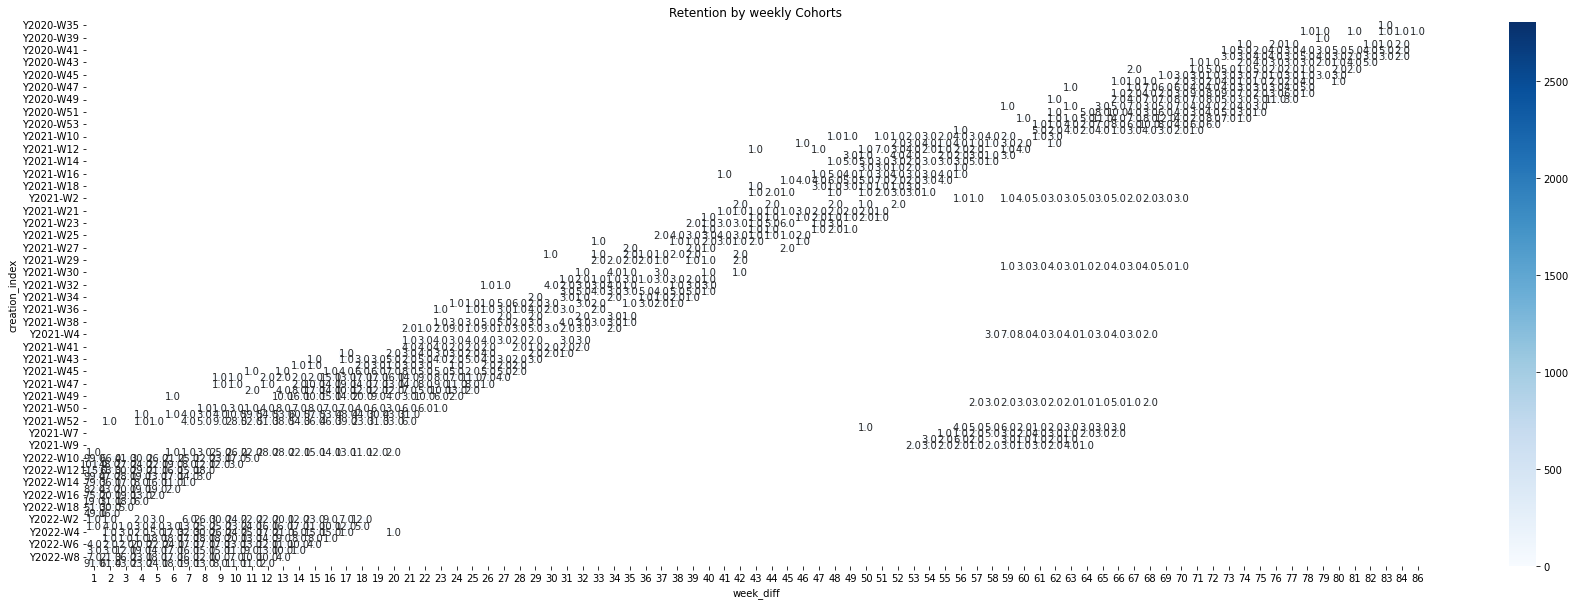

In [288]:
grouping = cohorts.groupby(['creation_index', 'week_diff'])

# Count the number of unique values per user_id

cohort_data = grouping['user_id'].apply(pd.Series.nunique).reset_index()

# Create a pivot

cohort_counts = cohort_data.pivot(index='creation_index', columns='week_diff', values='user_id')

# Select the first column and store it to cohort_sizes

cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows

retention = cohort_counts.divide(cohort_sizes, axis=0)*100
                                  

plt.figure(figsize=(30,10))

# Add a title

plt.title('Retention by weekly Cohorts')

# Create the heatmap

sns.heatmap(data=retentionb,
annot = True,
cmap = "Blues",
vmin = 0.0,
vmax = list(retention.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
           )
plt.show();

### Maturity table FY22

### Exploration - Maturity table by weeks

In [125]:
#Create a DataFrame for cochorts
cohorts_FY22=raw_data[["user_id","client_event_time","user_creation_time","id"]].copy()

In [126]:
#Map creation_index Year-Month index
cohorts_FY22["creation_year"]=cohorts_FY22["user_creation_time"].map(lambda x: get_year(x))
cohorts_FY22["creation_week"]=cohorts_FY22["user_creation_time"].map(lambda x: get_week(x))
cohorts_FY22=cohorts_FY22[cohorts_FY22["creation_year"]==2022]

In [127]:
# Calculate difference in weeks
        
cohorts_FY22["week_diff"] = (cohorts_FY22["client_event_time"]-cohorts_FY22["user_creation_time"]).map(lambda x: int(np.ceil(x.days/7))+1)

In [128]:
cohorts_FY22["user_id"].nunique

<bound method IndexOpsMixin.nunique of 58             0
59             0
60             0
61             0
62             0
           ...  
1320224    72314
1320225    72314
1320226        0
1320227        0
1320228        0
Name: user_id, Length: 755771, dtype: int64>

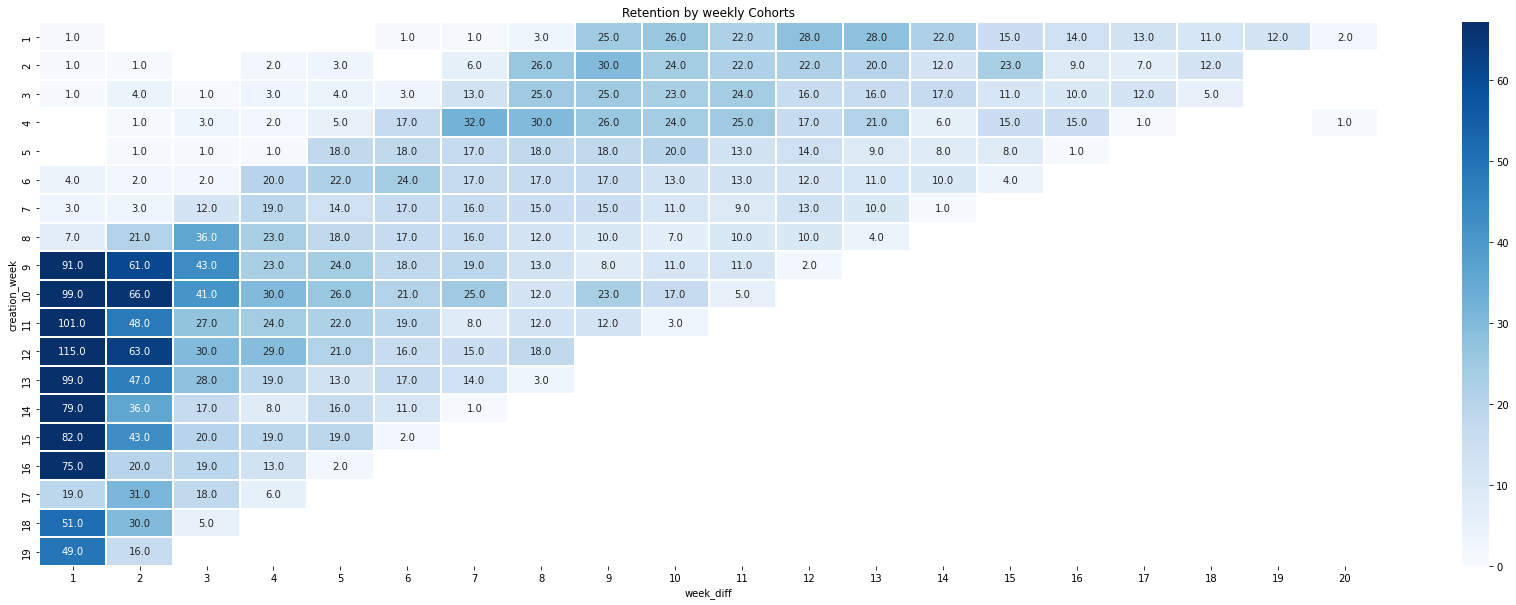

In [129]:
grouping = cohorts_FY22.groupby(['creation_week', 'week_diff'])

# Count the number of unique values per user_id


cohort_data = grouping['user_id'].apply(pd.Series.nunique).reset_index()

# Create a pivot

cohort_counts = cohort_data.pivot(index='creation_week', columns='week_diff', values='user_id')

# Select the first column and store it to cohort_sizes

#cohort_sizes = cohort_counts.iloc[:,0]
grouping2 = cohorts_FY22.groupby(['creation_week'])
cohort_sizes=grouping2["user_id"].apply(pd.Series.nunique).reset_index()["user_id"]
cohorts_list=cohorts_FY22["creation_week"].unique()
cohorts_list.sort()
# Divide the cohort count by cohort sizes along the rows

retention = cohort_counts.divide(cohort_sizes, axis=0)*100
                                 

plt.figure(figsize=(30,10))

# Add a title

plt.title('Retention by weekly Cohorts')

# Create the heatmap

sns.heatmap(data=cohort_counts,
annot = True,
cmap = "Blues",
vmin = 0.0,
vmax = list(retention.max().sort_values(ascending = False))[1]+3,
fmt = '.1f',
linewidth = 0.3,
 yticklabels=cohorts_list)
plt.show();

### Generate cohorts creation function

In [108]:
def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'user_id':pd.Series.nunique, "id":pd.Series.nunique, "session_id":pd.Series.nunique})
  
 
    cohorts.columns = ["user_id", "id", "session_id"]
    
    cohorts = cohorts[metric].unstack(0)
    
    return cohorts

def _generate_repeat_percentages(dataset,metric):
    
    dataset['type_of_order'] = np.where(dataset['client_event_time'] != dataset['user_creation_time'], 'repeat', 'first')
    repeat_perc = dataset.groupby(['cohort','type_of_order']).agg({
        'user_id':pd.Series.nunique,"id":pd.Series.nunique,"session_id":pd.Series.nunique}).unstack()


    repeat_perc = repeat_perc.stack().T.stack(level=0).fillna(0)
    repeat_perc['percentage repeat'] = repeat_perc['repeat']/repeat_perc.sum(axis=1)
    repeat_perc = repeat_perc.unstack(level=0).iloc[:,-3:]
    

    repeat_perc.columns = ['XXX %', 'XXX %', 'Session Repeat %']

    if metric == 'user_id':
        selection = repeat_perc.columns[0]
    if metric == 'id':
        selection = repeat_perc.columns[1]
    if metric == 'session_id':
        selection = repeat_perc.columns[2]
    if not selection:
        raise NotImplementedError('No repeat figures for specified metric')

    repeat_perc = repeat_perc[selection].reset_index()
   
    return repeat_perc, selection


In [119]:

def generate_cohort_analysis(df, metric, record_type='all', period_agg='weekly', fig=True, size=10, save_fig=True):
    
    """
    For metric use 'number_of_orders', 'number_of_items_bought'  or 'total_order_value'
    For record_type use 'all' or specific customer_type ['private','company','government']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """
    
    dataset = df.copy()
    
    
    if record_type != 'all':
        dataset = df[df.user_type == record_type].copy()
        
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='weekly':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%W'))
        dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%W'))
        dataset=dataset[dataset["cohort"]>="2022-01"]
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%m'))
        dataset=dataset[dataset["cohort"]>="2022-01"]
    elif period_agg=='daily':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        dataset=dataset[dataset["cohort"]>="2022-04-01"]
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
    
    
    
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)

    # generate new accounts data
    cohort_group_size = dataset.groupby('cohort').agg({'user_id': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort', 'New Users']

    # generate repeat data
    repeat_perc, selection = _generate_repeat_percentages(dataset,metric)

    # returns the data and does not plot anything
    if not fig:
        return (cohorts.T.join(new_accs.set_index('cohort')).fillna(0))
    
    #### Plot the Data ####
    # create the figures grid
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14, 1)})
    sns.despine(left=True, bottom=True, right=True)
    # plot new accounts
    Accounts = sns.barplot(x="New Users", y='cohort', data=new_accs, palette="Blues", ax=ax1)

    # plot retention matrix
    Heatmap = sns.heatmap(cohorts.T,
                          cmap="Blues",
                          annot=True,
                          fmt=".0f",
                          annot_kws={"size": size},
                          cbar=False,
                          yticklabels=False,
                          ax=ax2)

    title = 'Retention Matrix for "{}" - for Account Type "{}"'.format(metric, record_type)
    Heatmap.set_title(title)
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('session_period')

    # plot repeat table
    Repeats = sns.barplot(x=selection, y='cohort', data=repeat_perc, palette="Blues", ax=ax3)
    # removes y-axis label
    Repeats.yaxis.get_label().set_visible(False)
    # removes y-axis tickl labels
    Repeats.set(yticklabels=[])
    # removes y-axis ticks themselves
    Repeats.set(yticks=[])
    vals = Repeats.get_xticks()
    Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])


    # final layout touches

    plt.tight_layout()

    # saves the figure
    if save_fig:
        fig = Heatmap.get_figure()
        fig.savefig(metric+'RetentionMatrix'+record_type+'.png', bbox_inches='tight', dpi=600)

/var/folders/0b/xnxkv0n57js_989_n8cgs5y40000gn/T/ipykernel_5044/2098083417.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])


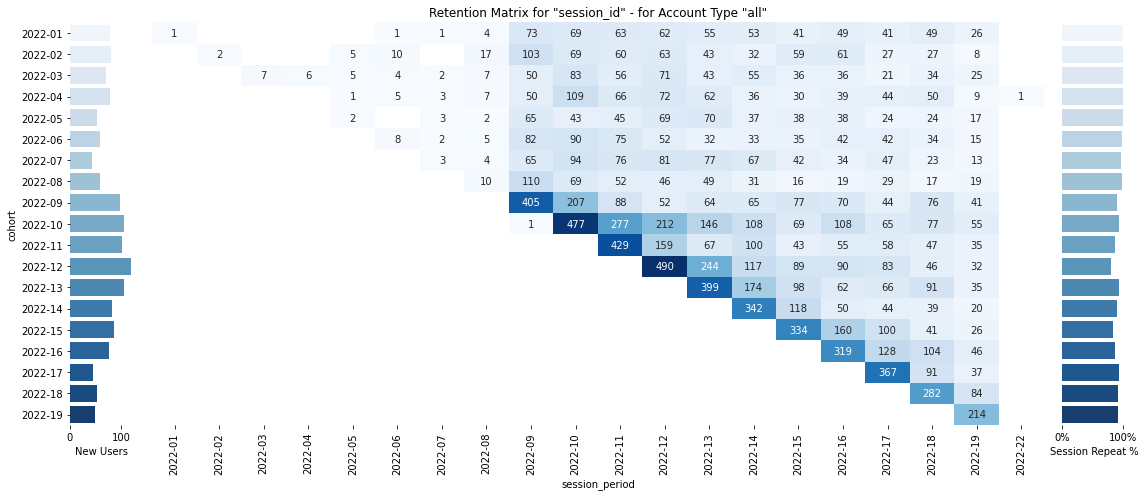

In [114]:
generate_cohort_analysis(raw_data, "session_id", period_agg='weekly', fig=True, size=10, save_fig=False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

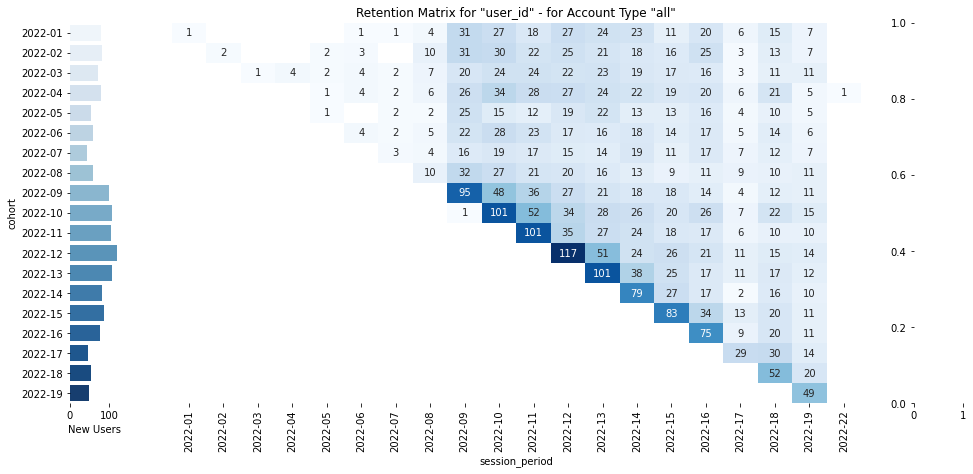

In [121]:
generate_cohort_analysis(raw_data, "user_id", period_agg='weekly', fig=True, size=10, save_fig=False)

/var/folders/0b/xnxkv0n57js_989_n8cgs5y40000gn/T/ipykernel_5044/2360866727.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])


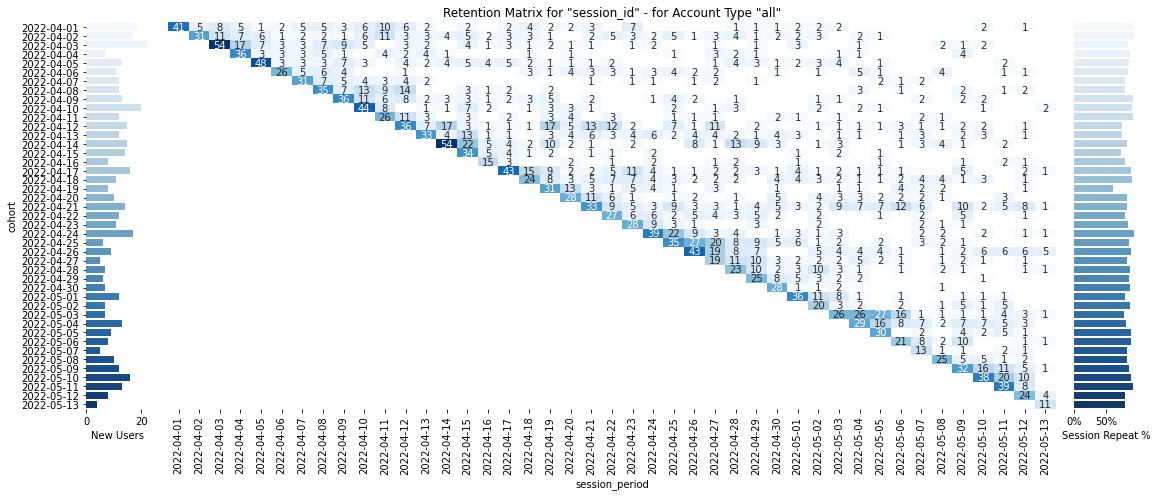

In [120]:
generate_cohort_analysis(raw_data, "session_id", period_agg='daily', fig=True, size=10, save_fig=False)

/var/folders/0b/xnxkv0n57js_989_n8cgs5y40000gn/T/ipykernel_5044/2098083417.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  Repeats.set_xticklabels(['{:,.0f}%'.format(x * 100) for x in vals])


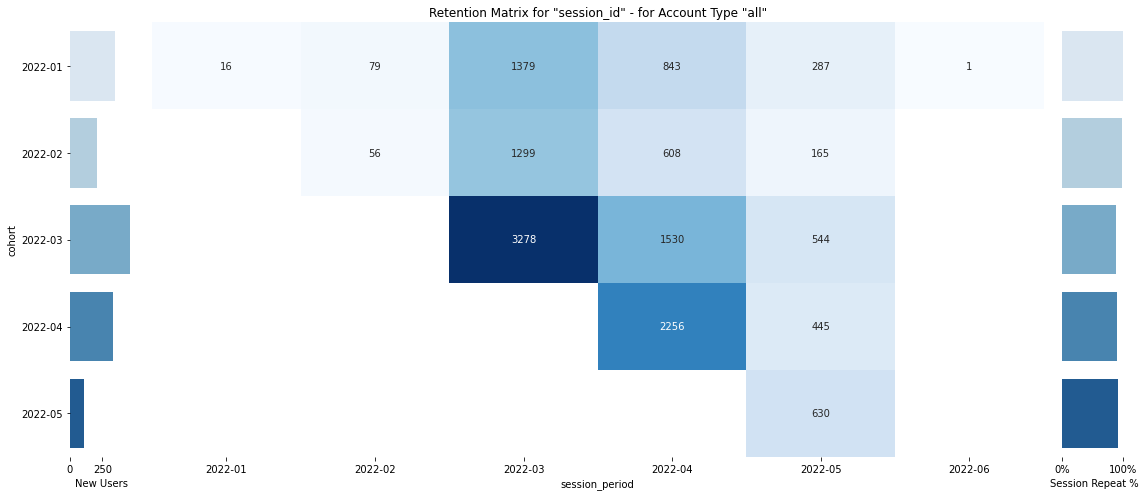

In [118]:
generate_cohort_analysis(raw_data, "session_id", period_agg='monthly', fig=True, size=10, save_fig=False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

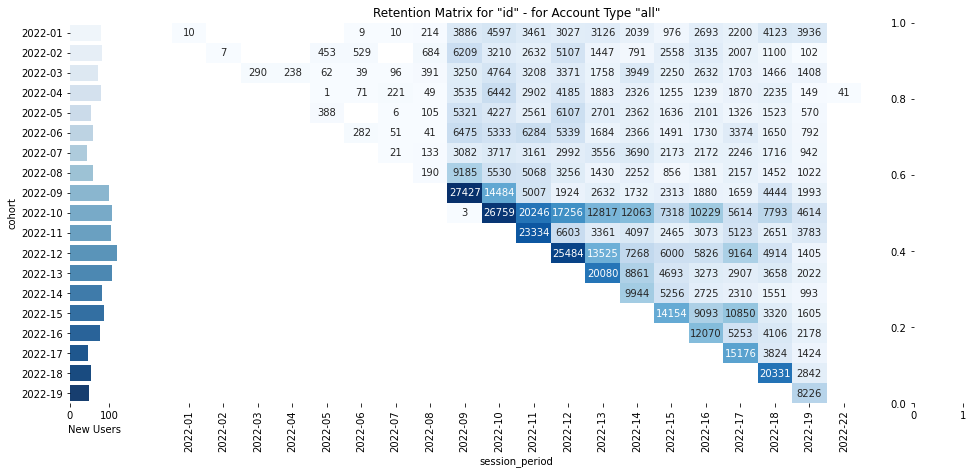

In [116]:
generate_cohort_analysis(raw_data, "id", period_agg='weekly', fig=True, size=10, save_fig=False)

In [87]:
def generate_daily_cohorts(data):
    
    """
    This function create a column in a DataFrame to map users by day of creation date.
    Creation date has the following format YYYY-MM-DD
    """
    #convert pandas timestamp to datetime object and remove timezone
    data["user_creation_time"]=data["user_creation_time"].map(lambda x: x.to_pydatetime())
    data["user_creation_time"]=data["user_creation_time"].map(lambda x: x.replace(tzinfo=None))
    
    #convert dates to string with YYYY-MM-DD format
    data["daily_cohorts"]=data["user_creation_time"].map(lambda x: f"{x.year}-{x.month}-{x.day}")
    
    return data
    
    

In [92]:
def generate_weekly_cohorts(data):
    
    """
    This function create a column in a DataFrame to map users by week of creation date.
    Creation date has the following format YYYY-WW
    """
    #convert pandas timestamp to datetime object and remove timezone
    data["user_creation_time"]=data["user_creation_time"].map(lambda x: x.to_pydatetime())
    data["user_creation_time"]=data["user_creation_time"].map(lambda x: x.replace(tzinfo=None))
    
    #convert dates to string with YYYY-MM-DD format
    data["weekly_cohorts"]=data["user_creation_time"].map(lambda x: f"{x.year}-{x.isocalendar()[1]}")
    
    return data
    
    

In [95]:
def generate_monthly_cohorts(data):
    
    """
    This function create a column in a DataFrame to map users by month of creation date.
    Creation date has the following format YYYY-MM
    """
    #convert pandas timestamp to datetime object and remove timezone
    data["user_creation_time"]=data["user_creation_time"].map(lambda x: x.to_pydatetime())
    data["user_creation_time"]=data["user_creation_time"].map(lambda x: x.replace(tzinfo=None))
    
    #convert dates to string with YYYY-MM-DD format
    data["monthly_cohorts"]=data["user_creation_time"].map(lambda x: f"{x.year}-{x.month}")
    
    return data
    
    

In [82]:
test_df=raw_data.sample(100)
test_df.shape

(100, 15)

In [89]:
test_df.head()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id,daily_cohorts
316244,Dambach-la-Ville,2022-03-10 07:44:25.043000+00:00,France,iPad 6,4886,[Scene] Enter,False,French,15.1,Bas-Rhin,1646895473758,1.0.1,2021-11-20 14:58:36.908,65582,208286,2021-11-20
308814,Saverne,2022-03-04 10:19:42.086000+00:00,France,iPad 6,4271,[Scene] Enter,False,French,15.1,Bas-Rhin,1646388445995,1.0.2,2021-11-29 08:18:15.808,66196,65229,2021-11-29
517719,Markham,2022-03-01 16:10:42.390000+00:00,Canada,iPad Air,401,[Scene] Enter,False,English,12.5.5,Ontario,1646149969566,4.0.1,2020-10-09 14:07:28.632,17013,6435,2020-10-9
451420,Mandeville,2022-04-06 21:54:53.384000+00:00,United States,"iPad8,9",1641,[Scaffolding] Scaffolding,False,English,14.7.1,Louisiana,1649277620213,5.2.0,2021-03-16 19:53:19.887,16280,705623,2021-3-16
181463,Taipa,2022-03-28 13:18:58.323000+00:00,Macau,iPad 6,307,[Scene] Enter,False,English,14.6,None,1648473447866,1.3.0,2022-03-28 09:57:37.944,71870,554288,2022-3-28


In [97]:
generate_daily_cohorts(test_df)

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id,daily_cohorts,weekly_cohorts,monthly_cohorts
316244,Dambach-la-Ville,2022-03-10 07:44:25.043000+00:00,France,iPad 6,4886,[Scene] Enter,False,French,15.1,Bas-Rhin,1646895473758,1.0.1,2021-11-20 14:58:36.908,65582,208286,2021-11-20,2021-46,2021-11
308814,Saverne,2022-03-04 10:19:42.086000+00:00,France,iPad 6,4271,[Scene] Enter,False,French,15.1,Bas-Rhin,1646388445995,1.0.2,2021-11-29 08:18:15.808,66196,65229,2021-11-29,2021-48,2021-11
517719,Markham,2022-03-01 16:10:42.390000+00:00,Canada,iPad Air,401,[Scene] Enter,False,English,12.5.5,Ontario,1646149969566,4.0.1,2020-10-09 14:07:28.632,17013,6435,2020-10-9,2020-41,2020-10
451420,Mandeville,2022-04-06 21:54:53.384000+00:00,United States,"iPad8,9",1641,[Scaffolding] Scaffolding,False,English,14.7.1,Louisiana,1649277620213,5.2.0,2021-03-16 19:53:19.887,16280,705623,2021-3-16,2021-11,2021-3
181463,Taipa,2022-03-28 13:18:58.323000+00:00,Macau,iPad 6,307,[Scene] Enter,False,English,14.6,None,1648473447866,1.3.0,2022-03-28 09:57:37.944,71870,554288,2022-3-28,2022-13,2022-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21329,Cavaillon,2022-03-22 07:46:53.775000+00:00,France,iPad 4,389,[Scene] Enter,False,French,10.3.3,Vaucluse,1647934646196,9.1.3,2021-08-17 13:33:28.062,61137,458373,2021-8-17,2021-33,2021-8
1149147,Nepean,2022-03-24 21:07:16.756000+00:00,Canada,iPad Air 2,1211,[Scene] Enter,False,English,13.3.1,Ontario,1648154461216,1.0.7,2022-01-17 11:45:13.037,68692,495988,2022-1-17,2022-3,2022-1
1135518,Boisbriand,2022-03-18 00:24:23.862000+00:00,Canada,iPad Air 2,324,[Game] Pause,False,French,12.4.1,Quebec,1647563062303,1.0.1,2021-11-22 23:36:39.073,65692,356653,2021-11-22,2021-47,2021-11
204926,Saint-Constant,2022-03-29 14:34:40.474000+00:00,Canada,iPad 6,1203,[Scene] Enter,False,French,14.4.2,Quebec,1648564277901,4.1.0,2020-11-16 15:57:09.723,41447,574567,2020-11-16,2020-47,2020-11


In [96]:
generate_monthly_cohorts(test_df)

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id,daily_cohorts,weekly_cohorts,monthly_cohorts
316244,Dambach-la-Ville,2022-03-10 07:44:25.043000+00:00,France,iPad 6,4886,[Scene] Enter,False,French,15.1,Bas-Rhin,1646895473758,1.0.1,2021-11-20 14:58:36.908,65582,208286,2021-46,2021-46,2021-11
308814,Saverne,2022-03-04 10:19:42.086000+00:00,France,iPad 6,4271,[Scene] Enter,False,French,15.1,Bas-Rhin,1646388445995,1.0.2,2021-11-29 08:18:15.808,66196,65229,2021-48,2021-48,2021-11
517719,Markham,2022-03-01 16:10:42.390000+00:00,Canada,iPad Air,401,[Scene] Enter,False,English,12.5.5,Ontario,1646149969566,4.0.1,2020-10-09 14:07:28.632,17013,6435,2020-41,2020-41,2020-10
451420,Mandeville,2022-04-06 21:54:53.384000+00:00,United States,"iPad8,9",1641,[Scaffolding] Scaffolding,False,English,14.7.1,Louisiana,1649277620213,5.2.0,2021-03-16 19:53:19.887,16280,705623,2021-11,2021-11,2021-3
181463,Taipa,2022-03-28 13:18:58.323000+00:00,Macau,iPad 6,307,[Scene] Enter,False,English,14.6,None,1648473447866,1.3.0,2022-03-28 09:57:37.944,71870,554288,2022-13,2022-13,2022-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21329,Cavaillon,2022-03-22 07:46:53.775000+00:00,France,iPad 4,389,[Scene] Enter,False,French,10.3.3,Vaucluse,1647934646196,9.1.3,2021-08-17 13:33:28.062,61137,458373,2021-33,2021-33,2021-8
1149147,Nepean,2022-03-24 21:07:16.756000+00:00,Canada,iPad Air 2,1211,[Scene] Enter,False,English,13.3.1,Ontario,1648154461216,1.0.7,2022-01-17 11:45:13.037,68692,495988,2022-3,2022-3,2022-1
1135518,Boisbriand,2022-03-18 00:24:23.862000+00:00,Canada,iPad Air 2,324,[Game] Pause,False,French,12.4.1,Quebec,1647563062303,1.0.1,2021-11-22 23:36:39.073,65692,356653,2021-47,2021-47,2021-11
204926,Saint-Constant,2022-03-29 14:34:40.474000+00:00,Canada,iPad 6,1203,[Scene] Enter,False,French,14.4.2,Quebec,1648564277901,4.1.0,2020-11-16 15:57:09.723,41447,574567,2020-47,2020-47,2020-11


# Exploration Scaffolding

In [41]:
raw_data=extract()

In [42]:
raw_data.head()

,city,client_event_time,country,device_model,event_id,event_type,is_attribution_event,language,os_version,region,session_id,start_version,user_creation_time,user_id,id
0,Newcastle upon Tyne,2022-03-05 16:21:14.284000+00:00,United Kingdom,"iPad13,10",148,[Game] Pause,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93358
1,Newcastle upon Tyne,2022-03-05 16:21:50.233000+00:00,United Kingdom,"iPad13,10",154,[Game] Pause,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93540
2,Newcastle upon Tyne,2022-03-05 16:13:58.157000+00:00,United Kingdom,"iPad13,10",97,[Game] Start,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93485
3,Newcastle upon Tyne,2022-03-05 16:18:32.980000+00:00,United Kingdom,"iPad13,10",109,[Scene] Enter,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93260
4,Newcastle upon Tyne,2022-03-05 16:18:33.329000+00:00,United Kingdom,"iPad13,10",112,[Scene] Enter,False,English,15.2.1,Newcastle upon Tyne,1646496838159,1.0.7,2021-12-25 10:32:21.493000+00:00,39843,93263


In [45]:
scaffolding_df=raw_data.copy()
scaffolding_df.columns

Index(['city', 'client_event_time', 'country', 'device_model', 'event_id',
       'event_type', 'is_attribution_event', 'language', 'os_version',
       'region', 'session_id', 'start_version', 'user_creation_time',
       'user_id', 'id'],
      dtype='object')

In [46]:
scaffolding_df=scaffolding_df[['client_event_time', 'event_id',
       'event_type', 'session_id', 'user_creation_time',
       'user_id', 'id']]

In [47]:
scaffolding_df.event_type.unique()

array(['[Game] Pause', '[Game] Start', '[Scene] Enter', '[Scene] Leave',
       '[Action] Click', '[Activity] Stop', '[Activity] Start',
       '[OB] CommPreview', '[OB] DoYouHaveKit', '[OB] HasKitYes',
       '[OB] Email', '[OB] VerifCode', '[OB] Type', '[Account] Sign Up',
       '[OB] ProfileName', '[OB] ProfileBirthdate', '[Profile] Create',
       '[Profile] Update', '[OB] ProductSelection', '[OB] ProductHelp',
       '[OB] ProductActivation', '[Activation] New Activation',
       '[Activation] Product', '[Activation] Piece', '[OB] Success',
       '[Activation] Game', '[Error] Error', '[Activity] Good Answer',
       '[Activity] Wrong Answer', '[Scaffolding] Scaffolding',
       '[OB] HasKitNo', '[OB] DiscoverTrial', '[OB] ClickTrial',
       '[OB] ClickStore', '[OB] TrialStart', '[Popup] Open',
       '[Account] Sign In', '[Scaffolding] Reset', '[OB] HasKeyNo',
       '[OB] RenewalSelection', '[OB] KeyRedeem', '[Popup] Close',
       '[OB] KeyFail', '[OB] ProductSK', '[OB] Produ

In [48]:
scaffolding_df=scaffolding_df[scaffolding_df["event_type"]=="[Scaffolding] Scaffolding"]

In [49]:
scaffolding_df

,client_event_time,event_id,event_type,session_id,user_creation_time,user_id,id
275,2022-03-06 16:54:20.488000+00:00,163,[Scaffolding] Scaffolding,1646585321901,2022-03-06 02:01:54.501000+00:00,70958,110371
276,2022-03-06 02:44:15.946000+00:00,101,[Scaffolding] Scaffolding,1646534569984,2022-03-06 02:01:54.501000+00:00,70958,115438
277,2022-03-06 02:48:25.554000+00:00,134,[Scaffolding] Scaffolding,1646534569984,2022-03-06 02:01:54.501000+00:00,70958,115466
278,2022-03-06 02:51:04.198000+00:00,148,[Scaffolding] Scaffolding,1646534569984,2022-03-06 02:01:54.501000+00:00,70958,115500
279,2022-03-06 02:46:34.826000+00:00,122,[Scaffolding] Scaffolding,1646534569984,2022-03-06 02:01:54.501000+00:00,70958,115567
...,...,...,...,...,...,...,...
1320183,2022-05-03 17:24:13.699000+00:00,684,[Scaffolding] Scaffolding,1651598271776,2022-02-03 19:32:56.151000+00:00,69619,1148511
1320184,2022-05-03 17:27:24.542000+00:00,698,[Scaffolding] Scaffolding,1651598271776,2022-02-03 19:32:56.151000+00:00,69619,1148621
1320185,2022-05-03 17:22:59.409000+00:00,672,[Scaffolding] Scaffolding,1651598271776,2022-02-03 19:32:56.151000+00:00,69619,1148761
1320186,2022-05-04 18:20:41.683000+00:00,730,[Scaffolding] Scaffolding,1651688274826,2022-02-03 19:32:56.151000+00:00,69619,1171510


In [57]:
def _generate_cohorts(dataset, metric):
    cohorts = dataset.groupby(['cohort','order_period']).agg({
        'user_id':pd.Series.nunique, "id":pd.Series.nunique, "session_id":pd.Series.nunique})
  
 
    cohorts.columns = ["user_id", "id", "session_id"]
    
    cohorts = cohorts[metric].unstack(0)
    
    return cohorts

In [64]:
def generate_cohort_analysis(df, metric, record_type='all', period_agg='weekly', fig=True, size=10, save_fig=True):
    
    """
    For metric use 'number_of_orders', 'number_of_items_bought'  or 'total_order_value'
    For record_type use 'all' or specific customer_type ['private','company','government']
    no_fig controlls the output of a figure, by default True (i.e. no figure)
    """
    
    dataset = df.copy()
    
    
    if record_type != 'all':
        dataset = df[df.user_type == record_type].copy()
        
    # format dates (i.e. map customers into their cohort and orders into the respective order period)
    if period_agg=='weekly':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%W'))
        dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%W'))
        dataset=dataset[dataset["cohort"]>="2022-01"]
    elif period_agg=='monthly':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%m'))
        dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%m'))
        dataset=dataset[dataset["cohort"]>="2022-01"]
    elif period_agg=='daily':
        dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
        dataset=dataset[dataset["cohort"]>="2022-04-01"]
    else:
        raise NotImplementedError(f'period_agg: {period_agg} is not implemented')
    
    
    
    # generate cohorts
    cohorts = _generate_cohorts(dataset,metric)

    # generate new accounts data
    cohort_group_size = dataset.groupby('cohort').agg({'user_id': pd.Series.nunique})
    new_accs = cohort_group_size.reset_index()
    new_accs.columns = ['cohort', 'New Users']

    # returns the data and does not plot anything
    if not fig:
        return (cohorts.T.join(new_accs.set_index('cohort')).fillna(0))
    
    #### Plot the Data ####
    # create the figures grid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14)})
    sns.despine(left=True, bottom=True, right=True)
    # plot new accounts
    Accounts = sns.barplot(x="New Users", y='cohort', data=new_accs, palette="Blues", ax=ax1)

    # plot retention matrix
    Heatmap = sns.heatmap(cohorts.T,
                          cmap="Blues",
                          annot=True,
                          fmt=".0f",
                          annot_kws={"size": size},
                          cbar=False,
                          yticklabels=False,
                          ax=ax2)

    title = '# of scaffoldings" - for Account Type "{}"'.format(metric, record_type)
    Heatmap.set_title(title)
    Heatmap.yaxis.get_label().set_visible(False)
    Heatmap.set_xlabel('session_period')

    # final layout touches

    plt.tight_layout()

    # saves the figure
    if save_fig:
        fig = Heatmap.get_figure()
        fig.savefig(metric+'RetentionMatrix'+record_type+'.png', bbox_inches='tight', dpi=600)

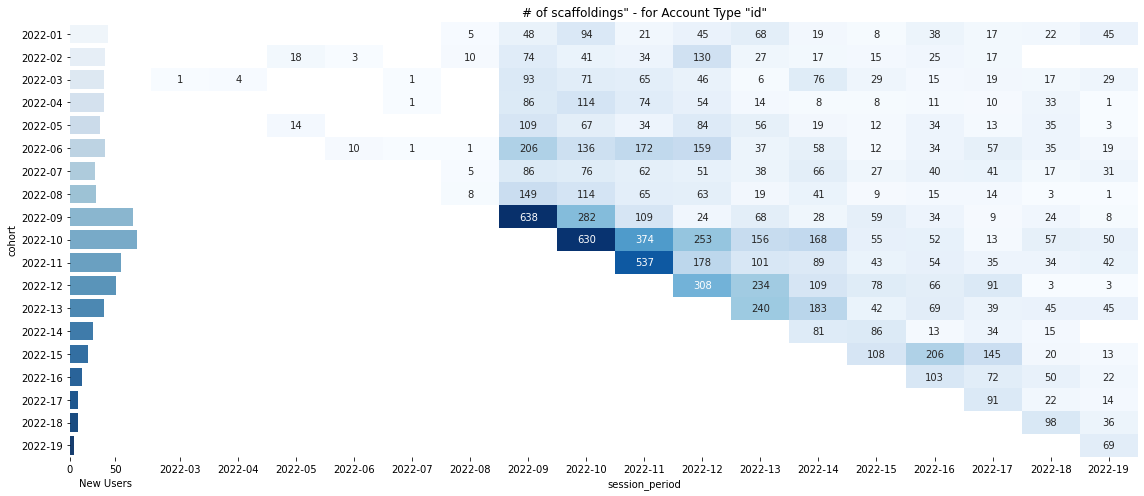

In [65]:
generate_cohort_analysis(scaffolding_df, "id", record_type='all', period_agg='weekly', fig=True, size=10, save_fig=True)

Text(0.5, 42.0, 'session_period')

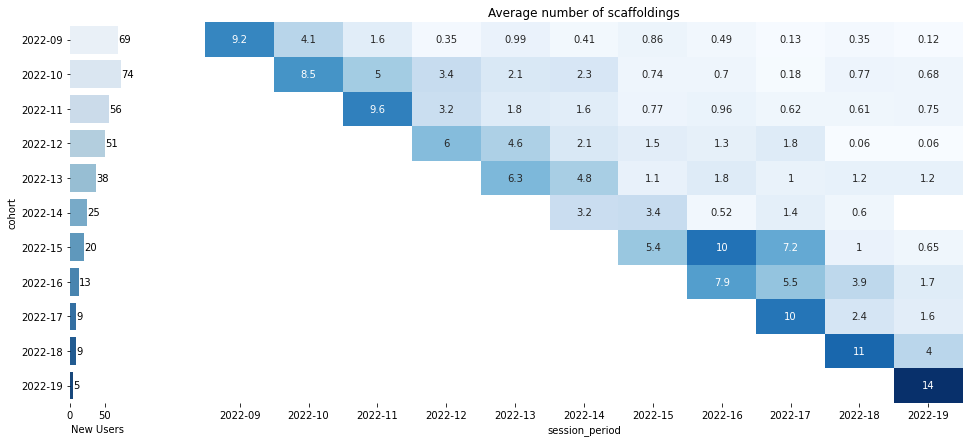

In [108]:
dataset = scaffolding_df.copy()



dataset['cohort'] = dataset['user_creation_time'].apply(lambda x: x.strftime('%Y-%W'))
dataset['order_period'] = dataset['client_event_time'].apply(lambda x: x.strftime('%Y-%W'))
dataset=dataset[dataset["cohort"]>="2022-09"]


cohorts = dataset.groupby(['cohort','order_period']).agg({
    'user_id':pd.Series.nunique, "id":pd.Series.nunique, "session_id":pd.Series.nunique})

cohorts.columns = ["user_id", "id", "session_id"]

cohorts = cohorts["id"].unstack(0)


# Compute the # of users per cohort
cohort_group_size = dataset.groupby('cohort').agg({'user_id': pd.Series.nunique})
new_accs = cohort_group_size.reset_index()
new_accs.columns = ['cohort', 'New Users']
cohort_sizes=new_accs["New Users"]



for i in range(0,cohorts.shape[1]):
    cohorts.iloc[:,i]=round(cohorts.iloc[:,i]/cohort_sizes[i],2)
    
#### Plot the Data ####
# create the figures grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': (1, 14)})
sns.despine(left=True, bottom=True, right=True)
# plot new accounts
Accounts = sns.barplot(x="New Users", y='cohort', data=new_accs, palette="Blues", ax=ax1,)
ax1.bar_label(ax1.containers[0])
# plot retention matrix
Heatmap = sns.heatmap(cohorts.T,
                      cmap="Blues",
                      annot=True,
                      
                      annot_kws={"size": 10},
                      cbar=False,
                      yticklabels=False,
                      ax=ax2)
title = 'Average number of scaffoldings'
Heatmap.set_title(title)
Heatmap.yaxis.get_label().set_visible(False)
Heatmap.set_xlabel('session_period')

In [109]:
new_accs

,cohort,New Users
0,2022-09,69
1,2022-10,74
2,2022-11,56
3,2022-12,51
4,2022-13,38
5,2022-14,25
6,2022-15,20
7,2022-16,13
8,2022-17,9
9,2022-18,9


# Exploration Users per game/scenes...

In [111]:
from google.oauth2 import service_account

def extract():
    # Construct a BigQuery client object.

    key_path = "/Users/David/code/dperiers/GITHUB_NICKNAME/gcp/marbotic-587600c2c13f.json"

    credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)
    
    client = bigquery.Client(project="marbotic", credentials=credentials)

    query = """
        SELECT *
        FROM `marbotic.marbotic_dataset.user_properties`
      
    """

    query_job = client.query(query)  # Make an API request.
    results=query_job.result().to_dataframe() # Waits for job to complete.

    return pd.DataFrame(results)

In [112]:
user_properties=extract()

In [113]:
user_properties.head()

,Newsletter,Type,Country,Language,ProfileType2,ReceiveNewsletter,LoggedIn,Products_Sesame_Street_Numbers,Products_Smart_Shapes,Products_Smart_Numbers,...,Games_Marbotic_Letters,Games_More_Or_Less,Games_Marbotic,Games_Vocabubble,event_id,client_event_time,user_creation_time,user_id,id,Products_Sensory_kit
0,False,Teacher,LU,English,None,None,None,0,0,0,...,0,0,0,0,1,2022-03-03 10:17:33.279000+00:00,2022-03-03 10:15:15.799000+00:00,0,38695,NaN
1,False,Teacher,LU,English,None,None,None,0,0,0,...,0,0,0,0,2,2022-03-03 10:17:33.279000+00:00,2022-03-03 10:15:15.799000+00:00,0,38696,NaN
2,False,Parent,AT,English,None,None,None,0,0,0,...,0,0,0,0,9,2022-03-04 18:10:45.671000+00:00,2021-05-12 14:48:12.149000+00:00,0,70424,NaN
3,False,Parent,AT,English,None,None,None,0,0,0,...,0,0,0,0,1,2022-03-04 18:09:42.747000+00:00,2021-05-12 14:48:12.149000+00:00,0,70686,NaN
4,False,Parent,AT,English,None,None,None,0,0,0,...,0,0,0,0,2,2022-03-04 18:09:42.748000+00:00,2021-05-12 14:48:12.149000+00:00,0,70687,NaN


In [116]:
user_properties.shape

(1320229, 40)

[Text(0, 0, '283263'), Text(0, 0, '1.01463e+06')]

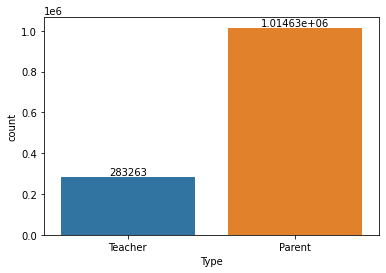

In [119]:
ax=sns.countplot(x="Type", data=user_properties, )
ax.bar_label(ax.containers[0])

In [121]:
user_properties.columns

Index(['Newsletter', 'Type', 'Country', 'Language', 'ProfileType2',
       'ReceiveNewsletter', 'LoggedIn', 'Products_Sesame_Street_Numbers',
       'Products_Smart_Shapes', 'Products_Smart_Numbers',
       'Products_Smart_Letters', 'Products_Deluxe_Learning_Kit',
       'Products_Nordic_Kit', 'Products_Smart_Letters_Lowercase',
       'Products_Smart_Kit', 'Pieces_Uppercase_Letters',
       'Pieces_Lowercase_Letters', 'Pieces_Sesame_Street_Numbers',
       'Pieces_Numbers', 'Pieces_English', 'Pieces_Nordic_Letters',
       'Pieces_Shapes', 'Games_Marbotic_Numbers', 'Games_Alphamonster',
       'Games_10_Fingers', 'Games_Lil_Reader', 'Games_Bla_Bla_Box',
       'Games_Sesame_Street_Numbers', 'Games_Up_To_100', 'Games_Smart_Shapes',
       'Games_Marbotic_Letters', 'Games_More_Or_Less', 'Games_Marbotic',
       'Games_Vocabubble', 'event_id', 'client_event_time',
       'user_creation_time', 'user_id', 'id', 'Products_Sensory_kit'],
      dtype='object')

In [131]:
games=['Games_Marbotic_Numbers', 'Games_Alphamonster',
       'Games_10_Fingers', 'Games_Lil_Reader', 'Games_Bla_Bla_Box',
       'Games_Sesame_Street_Numbers', 'Games_Up_To_100', 'Games_Smart_Shapes',
       'Games_Marbotic_Letters', 'Games_More_Or_Less', 'Games_Marbotic',
       'Games_Vocabubble']

In [132]:
products=['Products_Sesame_Street_Numbers',
       'Products_Smart_Shapes', 'Products_Smart_Numbers',
       'Products_Smart_Letters', 'Products_Deluxe_Learning_Kit',
       'Products_Nordic_Kit', 'Products_Smart_Letters_Lowercase',
       'Products_Smart_Kit']

In [133]:
pieces=['Pieces_Uppercase_Letters',
       'Pieces_Lowercase_Letters', 'Pieces_Sesame_Street_Numbers',
       'Pieces_Numbers', 'Pieces_English', 'Pieces_Nordic_Letters',
       'Pieces_Shapes']

[Text(0, 0, '0.586451'),
 Text(0, 0, '0.428911'),
 Text(0, 0, '0.0295653'),
 Text(0, 0, '0.812713'),
 Text(0, 0, '1e-05'),
 Text(0, 0, '0.043475'),
 Text(0, 0, '0.112496')]

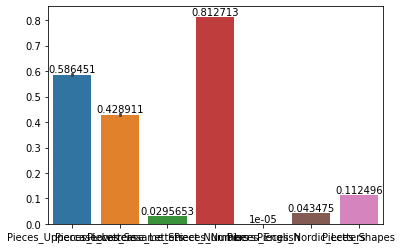

In [127]:
ax=sns.barplot(data=user_properties[pieces], )
ax.bar_label(ax.containers[0])

<AxesSubplot:>

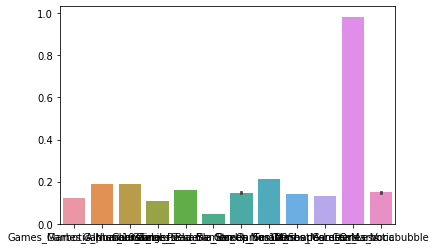

In [135]:
sns.barplot(data=user_properties[games])